### Framing classifier using BERT 

This model will shift towards a multi-class classification. The goal is to generate a model that can be used in social network analysis and social media content analysis while being fairly lightweight.
Downstream, it will be evaluated on a gold standard media frame corpus dataset. https://aclanthology.org/P15-2072.pdf

As the v1 notebook, this will contain all the experimental code and EDA for the initial stage of model development, carrying on from the lessons found in the topic classifier v2.

Frame prediction is much more complicated task than single topic prediction. We will see how far we can get with a base roBerta model with long-doc policy. Then we will likely expand to a larger model or combine BERTs. Data filtering to specific issue areas may also prove useful. 

Generic frames include non-issue specific frames that are generalizable across issues areas. The media frame corpus dataset lays out a set of 15


In [44]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from dotenv import load_dotenv
import os
import transformers
load_dotenv()  # looks for .env in current directory or parent
print(torch.__version__)
print(torch.cuda.is_available())


2.5.1
True


### Sample the data, ensure same categories as the media frames corpus

In [84]:
# Connect to server 
import psycopg2
conn = psycopg2.connect(
    dbname=os.getenv("DB_NAME"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    host=os.getenv("DB_HOST"),
    port=os.getenv("DB_PORT")
)
cur = conn.cursor()

# key: set the seed
cur.execute("SELECT setseed(0.42)")

# Do our join in database
cur.execute(f"""
           SELECT a.text_generic_frame, a.gpt_topic, a.political_leaning, a.title,  
           b.maintext
           FROM mm_framing_full a
           JOIN newsarticles b ON a.url = b.url
           ORDER BY RANDOM()
            LIMIT 5000
            """)

result= cur.fetchall()

print(cur.description)

cur.close()
conn.close()

df = pd.DataFrame(result, columns=["text_generic_frame", "gpt_topic", "political_leaning", "title", "article_text"])

del result

df.head()

(Column(name='text_generic_frame', type_code=25), Column(name='gpt_topic', type_code=25), Column(name='political_leaning', type_code=25), Column(name='title', type_code=25), Column(name='maintext', type_code=25))


,text_generic_frame,gpt_topic,political_leaning,title,article_text
0,"['Health and safety', 'Crime and punishment']",Accident,left_lean,One person injured in West Homestead crash inv...,"WEST HOMESTEAD, Pa. (KDKA) -- One person was t..."
1,"['Health and safety', 'Crime and punishment', ...",Crime,left_lean,Toddler dies in hot car after grandmother forg...,A 14-month-old girl died after her grandmother...
2,"['Legality, constitutionality and jurispudence...",Politics,center,Gov. Katie Hobbs stripped Arizona's 15 county ...,On the eve of the one-year anniversary of the ...
3,"['Labor and Workplace Issues', 'Fairness and E...",Labor,left_lean,New Jersey nurses strikes reaches day 4,Passion on the picket line wasn't waning four ...
4,"['Crime and punishment', 'Political']",Crime,right,Death of GOP activist in New Hampshire ruled a...,NEWYou can now listen to Fox News articles!\nT...


<Axes: ylabel='Frequency'>

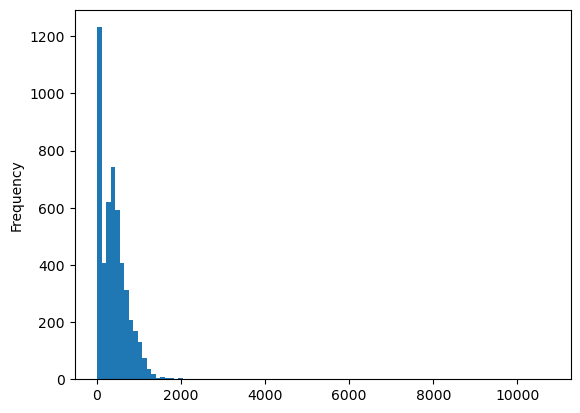

In [85]:
df['num_words'] = df['article_text'].str.split().str.len()

df['num_words'].plot.hist(bins=100)

### Initial data filtering
* Keep the same minimum length requirement  
* Noting the above histogram, we might exclude articles that are over 1000 words. This also gives BERT a fighting chance initially.


In [86]:
print(f"Original rows: {len(df)}")

df_filtered = df[(df['num_words'] > 100) & (df['num_words'] <= 1500)]
df = df_filtered.dropna()

print(f"Filtered rows: {len(df_filtered)}")

del df_filtered


Original rows: 5000
Filtered rows: 3787


### Examining and fixing the generic frames encoding


In [87]:
import ast

# .apply(ast.literal_eval) safely parses the string structure into a list
df['text_generic_frame'] = df['text_generic_frame'].apply(ast.literal_eval)

# Check the result:
print(type(df['text_generic_frame'][1]))

<class 'list'>


In [88]:
print(df['text_generic_frame'][1]) 

['Health and safety', 'Crime and punishment', 'Policy prescription and evaluation', 'Public Opinion']


In [81]:
all_frames = set(df['text_generic_frame'].sum())

counts = df['text_generic_frame'].explode().value_counts()

pd.set_option('display.max_rows', None)
print(counts)

# phew - at least the times when it's not part of the 15 categories seem to be extreme outliers

text_generic_frame
Quality of life                                                                                       1738
Policy prescription and evaluation                                                                    1636
Economic                                                                                              1526
Political                                                                                             1416
Crime and punishment                                                                                  1393
Public Opinion                                                                                        1350
Legality, constitutionality and jurispudence                                                          1076
Fairness and equality                                                                                 1052
Health and safety                                                                                      975
Cultural identity 

In [ ]:
pd.reset_option('display.max_rows')

all_frames

{'Achievement',
 'Adversity',
 'Age and Generation',
 'Age and Generational',
 'Ageism in the Workplace',
 'Animal Welfare',
 'Animal welfare',
 'Art',
 'Art and Entertainment',
 'Art and aesthetics',
 'Artistic Expression',
 'Assists',
 'Athletes',
 'Authoritarianism',
 'Baseball',
 'Bias-motivated crimes',
 'Bodily Autonomy',
 'Brand endorsement',
 'Capacity and resources',
 'Career and professional achievements',
 'Celebrity',
 'Celebrity and Entertainment',
 'Change',
 'Child welfare',
 'Climate and environment',
 'Climate and weather',
 'Climate change',
 'Climate change and environment',
 'Coaching',
 'Comeback',
 'Communication',
 'Community and Cultural Identity',
 'Community and Social',
 'Competition',
 'Competition and Achievement',
 'Competition and Performance',
 'Competition and market structure',
 'Conference change',
 'Controversy',
 'Corruption',
 'Corruption and accountability',
 'Court and legal proceedings',
 'Crime and Punishment',
 'Crime and punishment',
 'Crime 

Clearly the above is untenable and needs to be thoroughly cleaned to rematch to the media corpus original labels, which is what the original instruct model was suppossed to classify into.

In [89]:
# Cleaning up the framing labels
# 1. Define the 15 Official Labels exactly as they should be
official_labels = [
    "Economic", "Capacity and resources", "Morality", "Fairness and equality",
    "Legality, constitutionality and jurisprudence", "Policy prescription and evaluation",
    "Crime and punishment", "Security and defense", "Health and safety",
    "Quality of life", "Cultural identity", "Public opinion", "Political",
    "External regulation and reputation", "Other"
]


In [91]:

# 2. Create a normalization dictionary
# This maps the lowercase version of a label to the correct Official Label
# e.g., "economic" -> "Economic"
valid_map = {label.lower(): label for label in official_labels}

# 3. MANUALLY FIX THE DATA TYPOS AND SYNONYMS
# We map the "bad" versions to the "Official" keys
custom_fixes = {
    # The massive typo in your data 
    "legality, constitutionality and jurispudence": "Legality, constitutionality and jurisprudence",
    
    # Common variations found in your file
    "public opinion": "Public opinion",
    "quality of life": "Quality of life",
    "policy prescription and evaluation": "Policy prescription and evaluation",
    "cultural identity": "Cultural identity",
    "fairness and equality": "Fairness and equality",
    "safety and health": "Health and safety", # Reordering [cite: 16]
    "race and ethnicity": "Cultural identity", # Mapping sub-category to main [cite: 45]
}

# Update our valid_map with these custom fixes
valid_map.update(custom_fixes)

def clean_label_list(label_list):
    if not isinstance(label_list, list):
        return [] # return ["Other"] for empty rows "Other"
    
    clean_list = []
    for label in label_list:
        lbl_lower = str(label).lower().strip()
        
        if lbl_lower in valid_map:
            # It's a valid category, keep it
            clean_list.append(valid_map[lbl_lower])
        else:
            # It's a weird outlier -> Label it "Other" instead of deleting
            clean_list.append("Other")
            
    return list(set(clean_list))

# ---------------------------------------------------------
# Apply the cleaning
# ---------------------------------------------------------

# Apply the function to your column
df['cleaned_frames'] = df['text_generic_frame'].apply(clean_label_list)

# Check the results
print("Original row 1:", df['text_generic_frame'].iloc[1])
print("Cleaned row 1: ", df['cleaned_frames'].iloc[1])

# Verify we only have 15 categories left
all_clean_items = [item for sublist in df['cleaned_frames'] for item in sublist]
print("\nUnique categories remaining:", len(set(all_clean_items)))
print(pd.Series(all_clean_items).value_counts())

Original row 1: ['Legality, constitutionality and jurispudence', 'Policy prescription and evaluation', 'Fairness and equality', 'Cultural identity', 'Political']
Cleaned row 1:  ['Fairness and equality', 'Cultural identity', 'Legality, constitutionality and jurisprudence', 'Policy prescription and evaluation', 'Political']

Unique categories remaining: 15
Quality of life                                  1853
Policy prescription and evaluation               1674
Economic                                         1556
Political                                        1430
Crime and punishment                             1425
Legality, constitutionality and jurisprudence    1400
Public opinion                                   1393
Health and safety                                1099
Fairness and equality                            1073
Cultural identity                                1019
Security and defense                              970
External regulation and reputation              

In [93]:
# Keep rows where the list is NOT exactly ['Other']
df = df[df['cleaned_frames'].apply(lambda x: x != ['Other'])]
print(f"Rows remaining: {len(df)}")

Rows remaining: 3693


In [96]:
# I think we should also append the title to the front of the article text to help the model out
df['article_text'] = df['title'] + "\n" + df['article_text']

In [97]:
index = 4
print(f"Generic Topics: {df.iloc[index]['text_generic_frame']}")
print(df.iloc[index]['article_text'])

Generic Topics: ['Health and safety', 'Quality of life', 'Economic', 'Fairness and equality']
Gwyneth Paltrow body double for 'Shallow Hal' struggled with eating disorders after movie: 'Starving to death'
NEWYou can now listen to Fox News articles!
The body double for Gwyneth Paltrow's plus-size character in the 2001 comedy "Shallow Hal" says she developed eating disorders and was practically "starving to death" in the years after the movie came out.
In the movie, Jack Black's title character falls in love with Paltrow's character Rosemary after he's hypnotized to only see a woman's inner beauty, so while everyone else sees a morbidly obese woman, he only sees one who looks like the real Paltrow.
While Paltrow also played the overweight version of the character in the movie by donning a fat suit, Snitzer's body was used for closeups of Rosemary's arms, torso and thighs. According to an interview she did with The Guardian, she enjoyed being part of the filming and praised Black and Palt

### Tokenization + long doc policy
* At this point, I'm happy with the dataset quality, so we'll move forward with the defined pipeline

In [98]:
from transformers import AutoTokenizer

# choosing a base tokenizer model, this won't 
model_name = "FacebookAI/roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# generally want to keep the tokenizations in a separate variable rather than adding them back to the dataframe (for efficiency, taking advantage of the batching features of the huggingface tokenizer)

encodings = tokenizer(df['article_text'].tolist(),                      # we opt to dynamically do padding later with head/tail strategy
                      # hence we also don't need truncation here
                      )

Token indices sequence length is longer than the specified maximum sequence length for this model (640 > 512). Running this sequence through the model will result in indexing errors


In [99]:
# Code to set the unique head and tail of the articles
head_len = 320
tail_len = 190
content_len = head_len + tail_len          
max_len = content_len + 2  # [CLS] + [SEP]      

cls_id = tokenizer.cls_token_id
sep_id = tokenizer.sep_token_id
pad_id = tokenizer.pad_token_id

for i, ids in enumerate(encodings["input_ids"]):
    # ClS and Sep Id's are present in tokenized values, so do this
    if len(ids) >= 2 and ids[0] == cls_id and ids[-1] == sep_id:
        ids = ids[1:-1]

    # Head+tail on the content tokens
    if len(ids) > content_len:
        head = ids[:head_len]
        tail = ids[-tail_len:]
        ids = head + tail

    # Add specials back
    ids = [cls_id] + ids + [sep_id]

    # Build attention mask (1 for real tokens)
    mask = [1] * len(ids)

    # Pad (or truncate)
    if len(ids) < max_len:
        pad_n = max_len - len(ids)
        ids = ids + [pad_id] * pad_n
        mask = mask + [0] * pad_n
    else:
        ids = ids[:max_len]
        mask = mask[:max_len]

    # Write back
    encodings["input_ids"][i] = ids
    encodings["attention_mask"][i] = mask

# quick sanity check
for ids, mask in zip(encodings["input_ids"][:10], encodings["attention_mask"][:10]):
    assert len(ids) == 512 and len(mask) == 512
    print(ids[:3], sum(mask))

[0, 42093, 1371] 405
[0, 21964, 4] 512
[0, 34811, 9] 400
[0, 31722, 4822] 159
[0, 534, 16541] 512
[0, 17049, 5223] 453
[0, 46272, 10441] 512
[0, 4027, 2497] 512
[0, 448, 967] 512
[0, 42691, 139] 512


### PyTorch Dataset Creation

Using `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`

[Pytorch data tutorial](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html)

* Key change from topic classifier workflow is to establish multi-class prediction

To do this, need to change:
* label shape, we need it to be a binary vector (list of 0 and 1s) the length of total categories (15), we can use https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html
* standard multi-label loss functions (like `BCEWithLogitsLoss`) need targets to be floats, so we change our label tensor dtype to torch.float
* continue filtering out the non-tensor data stuff in batch loading

In [128]:
from sklearn.preprocessing import MultiLabelBinarizer
# Firstly we binarize the frame labels

#  Initialize and Fit
mlb = MultiLabelBinarizer(classes=official_labels)
mlb.fit(df['cleaned_frames']) # Fit on your data (or just the list of labels)

# Transform data into the binary matrix
# creates a big matrix of 0s and 1s
labels_matrix = mlb.transform(df['cleaned_frames'])

# sanity check
# labels_matrix.shape should be (Num_Rows, 15)
print(labels_matrix.shape)

# we should also save the binarizer object in case we need it later after training a good model
import joblib
joblib.dump(mlb, 'encoders/mlb_15_classes.pkl')

(3693, 15)


['encoders/mlb_15_classes.pkl']

In [129]:
# Modifying the below to record the raw text, but filter this out in batch processing since it's not a tensor

from torch.utils.data import Dataset

class NewsArticleDataset(Dataset):
    def __init__(self, encodings, labels_matrix, df):
        """
        encodings: result from tokenizer(text, truncation=True, padding=True)
        labels_matrix: Your Multi-Hot encoded vectors (List or Tensor)
        df: The pandas DataFrame containing metadata (gpt_topic, title, etc.)
        """
        # Tensor-ready data
        self.input_ids = encodings['input_ids']
        self.attention_mask = encodings['attention_mask']
        self.labels = labels_matrix 

        # Raw Text / Metadata (Stored as standard Python lists)
        # convert to list for indexing robustness
        self.article_text = df['article_text'].tolist()
        self.titles = df['title'].tolist()
        self.gpt_topics = df['gpt_topic'].tolist()
        self.political_leanings = df['political_leaning'].tolist()
        self.num_words = df['num_words'].tolist()
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        dict_to_return = {
            # Tensors for the model
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_mask[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float), # ensure float for loss calcs
            
            # Raw data for analysis/filtering later
            'article_text': self.article_text[idx],
            'title': self.titles[idx],
            'gpt_topic': self.gpt_topics[idx],
            'political_leaning': self.political_leanings[idx],
            'num_words': self.num_words[idx]
        }
        return dict_to_return

### Creating the test/train/val split

We can't so easily stratify like we did with the topic classifier, since we have so many unique combinations of labels, which seems to overwhelm the scikitlearn base stratifier. However, stratification is still quite important to expose the model appropriately to all the different combinations.

We can use a specialized method in iterative stratification. 

In [130]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import numpy as np
from torch.utils.data import Subset

# 1. Setup your data
# Ensure 'labels_matrix' is your MultiLabelBinarizer output (the 0s and 1s matrix)
# Shape should be (Num_Samples, Num_Classes)
N = len(labels_matrix)
X_indices = np.zeros(N) # Dummy input just for the splitter to index

# ---------------------------------------------------------
# SPLIT 1: Separate Train (80%) from Temp (20%)
# ---------------------------------------------------------
msss1 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)

# We use next(iter(...)) to grab the first split immediately
train_idx, temp_idx = next(iter(msss1.split(X_indices, labels_matrix)))

# ---------------------------------------------------------
# SPLIT 2: Separate Val (10%) from Test (10%)
# We split 'temp' in half (0.5 of 0.2 = 0.1 total)
# ---------------------------------------------------------
# Subset the labels for just the temp part
temp_labels = labels_matrix[temp_idx]
temp_dummy_X = np.zeros(len(temp_idx))

msss2 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=42)

# Get indices relative to the temp_idx list (0 to len(temp_idx))
relative_val_idx, relative_test_idx = next(iter(msss2.split(temp_dummy_X, temp_labels)))

# MAP BACK: Convert relative indices (0, 1, 2...) to original dataset indices (500, 12, 99...)
val_idx = temp_idx[relative_val_idx]
test_idx = temp_idx[relative_test_idx]

# ---------------------------------------------------------
# BUILD DATASET
# ---------------------------------------------------------
# Note: Use your NEW binary labels here, not the old ID list
full_dataset = NewsArticleDataset(encodings, labels_matrix, df) 

train = Subset(full_dataset, train_idx)
val   = Subset(full_dataset, val_idx)
test  = Subset(full_dataset, test_idx)

print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")

Train: 2958, Val: 349, Test: 386


### Creating the data loaders

In [132]:
# previously I was just parsing out the data set meta data when loading the batches, but there's a much more elegant way of doing this 
# we can make use of the dataloader collate_fn 

import torch

def parse_out_metadata_collate_fn(batch):
    """
    batch: list of dictionaries (the output of __getitem__ for each item in the batch)
    """
    # Initialize the output dictionary
    batch_out = {}
    
    # Handle Tensors: Stack them (Turn list of 1D tensors into one 2D tensor)
    # We explicitly list the keys we know are tensors
    tensor_keys = ['input_ids', 'attention_mask', 'labels']
    
    for key in tensor_keys:
        # stack stacks along a new dimension (batch dimension)
        batch_out[key] = torch.stack([item[key] for item in batch])
        
    # Handle Text/Metadata: Keep them as simple lists
    # We collect everything else that isn't a tensor key
    all_keys = batch[0].keys()
    text_keys = [k for k in all_keys if k not in tensor_keys]
    
    for key in text_keys:
        batch_out[key] = [item[key] for item in batch]
        
    return batch_out

In [133]:
# recreate the data loader, they rely on dataset + indices
batch_size = 16

from torch.utils.data import DataLoader

# data loaders handle our raw (non-tensor) article text automatically
train_loader = DataLoader(train, 
                          batch_size = batch_size, # number of articles to be fed into the model at once
                          shuffle = True, 
                          pin_memory= True,
                          collate_fn= parse_out_metadata_collate_fn)
val_loader = DataLoader(val, 
                          batch_size = batch_size, # number of articles to be fed into the model at once
                          shuffle = False, # false so eval is deterministic and reproducible
                          pin_memory= True,
                          collate_fn = parse_out_metadata_collate_fn)
test_loader = DataLoader(test, 
                          batch_size = batch_size, # number of articles to be fed into the model at once
                          shuffle = False,  # false, as above
                          pin_memory= True,
                          collate_fn = parse_out_metadata_collate_fn)

In [138]:
# Let's test on a batch as a sanity check
# grab a batch using iterator next()
batch = next(iter(train_loader))

print(batch['title'])
# so now we have our useful metadata in our batches


["FBI, CDC shredded for 'dropping the ball' on secret Chinese lab found in US: 'Reads like a movie script'", 'Best Aldi Foods to Buy, According to Culinary Expert of 10 Years', 'Call for UK ban on single-use vapes as more than 5m discarded each week', 'George Ford helps Sale end Leicester’s Premiership defence to reach final', 'Far-right Polish lawmaker uses fire extinguisher to put out Hanukkah candles in parliament', "Las Vegas 'lone wolf' terror attack foiled by FBI, police", 'Torres 2-run single helps Yankees outlast Red Sox 3-2 in doubleheader opener', 'Kenny Pickett is hoping for a major step forward in Year 2. The Steelers are counting on it.', 'Scabby the Rat gives bite to union protests, but is he at the tail end of his relevancy?', "Hollywood's writers strike is on the verge of ending. What happens next?", 'Sabir Jones in custody in subway shove, but worries remain among some straphangers', "'The View' goes off on ‘Governor Cruella’ Kristi Noem over killing dog: ‘Sign of a so

### Begin training loop

* This is our initial run with truncated text on a complicated multi-class classification with roBERTa, so expectations are not super high


In [145]:
# for a clean state, hard reset the GPU state
import torch, gc
gc.collect()
torch.cuda.empty_cache() 

For our optimizer setup, we'll shift to using multi label classification. The key difference is that we're using sigmoids instead of softmax in the classification layer, and we're allowing multiple nodes to fire as 'true predicted class'.

Multi-Label: Uses `BCEWithLogitsLoss` (Binary Cross Entropy). This treats every single category as an independent Yes/No question. It allows "Politics" to be 0.9 and "Crime" to also be 0.9 simultaneously.

In [143]:
from transformers import AutoModelForSequenceClassification

num_labels = labels_matrix.shape[1]

# Initialize Model with explicit problem_type
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=num_labels,
    problem_type="multi_label_classification" # forces BCEWithLogitsLoss internally
)
model.to('cuda')

# 3. define optimizer, same as with single classification
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=3e-5, 
    weight_decay=0.01
)

# Explicit Loss Function (Recommended for Custom Loops)
# Even though the model has it internally, defining it here gives you more control
# (e.g., adding class weights later)
criterion = torch.nn.BCEWithLogitsLoss()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Very key decision is now how **we define a correct prediction**, as fitting the entire row is a very strict requirement. 

Basically there's three choices
* Exact match ratio (fitting the whole row - very strcit)
* Hamming Accuracy (what % of individual boxes are correct?)
    * downside is that if a label has many 0's, model scores highly just by predicting 0
* F1 score - harmonic mean of precision and recall - much better, as usual, for this kind of task. ignores the easy zeros and focuses on the ones
    * We can use scikit-learn to implement this, `sklearn.metrics`

We go with F1 score


In [144]:
from sklearn.metrics import f1_score

epochs = 3
best_val_f1 = 0.0
save_path = "saved_models/framing_training_runs/best_model_state.bin"

for epoch in range(epochs):
    # ==========================
    # TRAINING
    # ==========================
    model.train()
    running_loss = 0.0

    for batch in train_loader:
        model_input_keys = ['input_ids', 'attention_mask', 'labels']

        # "Move to CUDA if key is in list, ELSE keep original value 'v'"
        batch = {k: (v.to("cuda") if k in model_input_keys else v) for k, v in batch.items()}
        
        article_text = batch.pop("article_text", None)
        
        # 2) forward pass 
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"] 
        )

        loss = outputs.loss 
        running_loss += loss.item()

        # 3) zero grad
        optimizer.zero_grad()

        # 4) backward
        loss.backward()

        # 5) step
        optimizer.step()
    
    # Print training loss for the epoch
    print(f"Epoch {epoch} | Train Loss: {running_loss/len(train_loader):.4f}")

    # ==========================
    # VALIDATION
    # ==========================
    model.eval()
    val_loss = 0.0

    # 1. Lists to store results for the whole epoch
    all_preds = []
    all_labels = []

    model_input_keys = ['input_ids', 'attention_mask', 'labels']

    with torch.no_grad():
        for batch in val_loader:
            # 2. Safer Move to GPU
            batch_tensors = {k: v.to("cuda") for k, v in batch.items() if k in model_input_keys}
            
            outputs = model(
                input_ids=batch_tensors["input_ids"],
                attention_mask=batch_tensors["attention_mask"],
                labels=batch_tensors["labels"],
            )
            val_loss += outputs.loss.item()

            # 3. Get Predictions
            logits = outputs.logits
            # Sigmoid + Threshold
            preds = (torch.sigmoid(logits) > 0.5).float()
            
            # 4. Collect inputs for sklearn (Move to CPU -> Numpy)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(batch_tensors["labels"].cpu().numpy())

    # 5. Stack and Calculate Metrics
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    # Micro F1: Global calculation (Total True Positives / Total Positives). Best for imbalanced data.
    val_f1_micro = f1_score(all_labels, all_preds, average='micro')

    # Macro F1: Calculate F1 for each class separately, then average. Good to see if rare classes are failing.
    val_f1_macro = f1_score(all_labels, all_preds, average='macro')

    # Exact Match Ratio: Strict "All or Nothing" accuracy (optional but good context)
    val_exact_acc = (all_preds == all_labels).all(axis=1).mean()

    print(
        f"Epoch {epoch} | val_loss={val_loss/len(val_loader):.4f} "
        f"| F1 (Micro)={val_f1_micro:.4f} | F1 (Macro)={val_f1_macro:.4f} | Exact Match={val_exact_acc:.4f}"
    )
    
    # checkpointing
    if val_f1_micro > best_val_f1:
        print(f"--> New Best Score! (Old: {best_val_f1:.4f} | New: {val_f1_micro:.4f})")
        print(f"--> Saving model to {save_path}...")
        best_val_f1 = val_f1_micro
        # Only save the weights (state_dict) to save space
        torch.save(model.state_dict(), save_path)
    else:
        print(f"--> No improvement. Best is still {best_val_f1:.4f}")

Epoch 0 | Train Loss: 0.5036
Epoch 0 | val_loss=0.4597 | F1 (Micro)=0.6026 | F1 (Macro)=0.5027 | Exact Match=0.0487
--> New Best Score! (Old: 0.0000 | New: 0.6026)
--> Saving model to saved_models/framing_training_runs/best_model_state.bin...
Epoch 1 | Train Loss: 0.4119
Epoch 1 | val_loss=0.4381 | F1 (Micro)=0.6575 | F1 (Macro)=0.6006 | Exact Match=0.0602
--> New Best Score! (Old: 0.6026 | New: 0.6575)
--> Saving model to saved_models/framing_training_runs/best_model_state.bin...
Epoch 2 | Train Loss: 0.3644
Epoch 2 | val_loss=0.4376 | F1 (Micro)=0.6646 | F1 (Macro)=0.6146 | Exact Match=0.0831
--> New Best Score! (Old: 0.6575 | New: 0.6646)
--> Saving model to saved_models/framing_training_runs/best_model_state.bin...
